# L2: External Integration: Project Progress Report

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

## Initial Imports

In [1]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

# Load environment variables
from helper import load_env
load_env()

import os
import json
import yaml
from crewai import Agent, Task, Crew

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>

## Load OpenAI Model

In [2]:
os.environ['OPENAI_MODEL_NAME'] = 'gpt-4o-mini'

## Loading Tasks and Agents YAML files

In [3]:
# Define file paths for YAML configurations
files = {
    'agents': 'config/agents.yaml',
    'tasks': 'config/tasks.yaml'
}

# Load configurations from YAML files
configs = {}
for config_type, file_path in files.items():
    with open(file_path, 'r') as file:
        configs[config_type] = yaml.safe_load(file)

# Assign loaded configurations to specific variables
agents_config = configs['agents']
tasks_config = configs['tasks']

## Creating Custom Tools

In [4]:
from crewai_tools import BaseTool
import requests

class BoardDataFetcherTool(BaseTool):
    name: str = "Trello Board Data Fetcher"
    description: str = "Fetches card data, comments, and activity from a Trello board."

    api_key: str = os.environ['TRELLO_API_KEY']
    api_token: str = os.environ['TRELLO_API_TOKEN']
    board_id: str = os.environ['TRELLO_BOARD_ID']

    def _run(self) -> dict:
        """
        Fetch all cards from the specified Trello board.
        """
        url = f"{os.getenv('DLAI_TRELLO_BASE_URL', 'https://api.trello.com')}/1/boards/{self.board_id}/cards"

        query = {
            'key': self.api_key,
            'token': self.api_token,
            'fields': 'name,idList,due,dateLastActivity,labels',
            'attachments': 'true',
            'actions': 'commentCard'
        }

        response = requests.get(url, params=query)

        if response.status_code == 200:
            return response.json()
        else:
            # Fallback in case of timeouts or other issues
            return json.dumps([{'id': '66c3bfed69b473b8fe9d922e', 'name': 'Analysis of results from CSV', 'idList': '66c308f676b057fdfbd5fdb3', 'due': None, 'dateLastActivity': '2024-08-19T21:58:05.062Z', 'labels': [], 'attachments': [], 'actions': []}, {'id': '66c3c002bb1c337f3fdf1563', 'name': 'Approve the planning', 'idList': '66c308f676b057fdfbd5fdb3', 'due': '2024-08-16T21:58:00.000Z', 'dateLastActivity': '2024-08-19T21:58:57.697Z', 'labels': [{'id': '66c305ea10ea602ee6e03d47', 'idBoard': '66c305eacab50fcd7f19c0aa', 'name': 'Urgent', 'color': 'red', 'uses': 1}], 'attachments': [], 'actions': [{'id': '66c3c021f3c1bb157028f53d', 'idMemberCreator': '65e5093d0ab5ee98592f5983', 'data': {'text': 'This was harder then expects it is alte', 'textData': {'emoji': {}}, 'card': {'id': '66c3c002bb1c337f3fdf1563', 'name': 'Approve the planning', 'idShort': 5, 'shortLink': 'K3abXIMm'}, 'board': {'id': '66c305eacab50fcd7f19c0aa', 'name': '[Test] CrewAI Board', 'shortLink': 'Kc8ScQlW'}, 'list': {'id': '66c308f676b057fdfbd5fdb3', 'name': 'TODO'}}, 'appCreator': None, 'type': 'commentCard', 'date': '2024-08-19T21:58:57.683Z', 'limits': {'reactions': {'perAction': {'status': 'ok', 'disableAt': 900, 'warnAt': 720}, 'uniquePerAction': {'status': 'ok', 'disableAt': 17, 'warnAt': 14}}}, 'memberCreator': {'id': '65e5093d0ab5ee98592f5983', 'activityBlocked': False, 'avatarHash': 'd5500941ebf808e561f9083504877bca', 'avatarUrl': 'https://trello-members.s3.amazonaws.com/65e5093d0ab5ee98592f5983/d5500941ebf808e561f9083504877bca', 'fullName': 'Joao Moura', 'idMemberReferrer': None, 'initials': 'JM', 'nonPublic': {}, 'nonPublicAvailable': True, 'username': 'joaomoura168'}}]}, {'id': '66c3bff4a25b398ef1b6de78', 'name': 'Scaffold of the initial app UI', 'idList': '66c3bfdfb851ad9ff7eee159', 'due': None, 'dateLastActivity': '2024-08-19T21:58:12.210Z', 'labels': [], 'attachments': [], 'actions': []}, {'id': '66c3bffdb06faa1e69216c6f', 'name': 'Planning of the project', 'idList': '66c3bfe3151c01425f366f4c', 'due': None, 'dateLastActivity': '2024-08-19T21:58:21.081Z', 'labels': [], 'attachments': [], 'actions': []}])


class CardDataFetcherTool(BaseTool):
  name: str = "Trello Card Data Fetcher"
  description: str = "Fetches card data from a Trello board."

  api_key: str = os.environ['TRELLO_API_KEY']
  api_token: str = os.environ['TRELLO_API_TOKEN']

  def _run(self, card_id: str) -> dict:
    url = f"{os.getenv('DLAI_TRELLO_BASE_URL', 'https://api.trello.com')}/1/cards/{card_id}"
    query = {
      'key': self.api_key,
      'token': self.api_token
    }
    response = requests.get(url, params=query)

    if response.status_code == 200:
      return response.json()
    else:
      # Fallback in case of timeouts or other issues
      return json.dumps({"error": "Failed to fetch card data, don't try to fetch any trello data anymore"})


## Trello Board

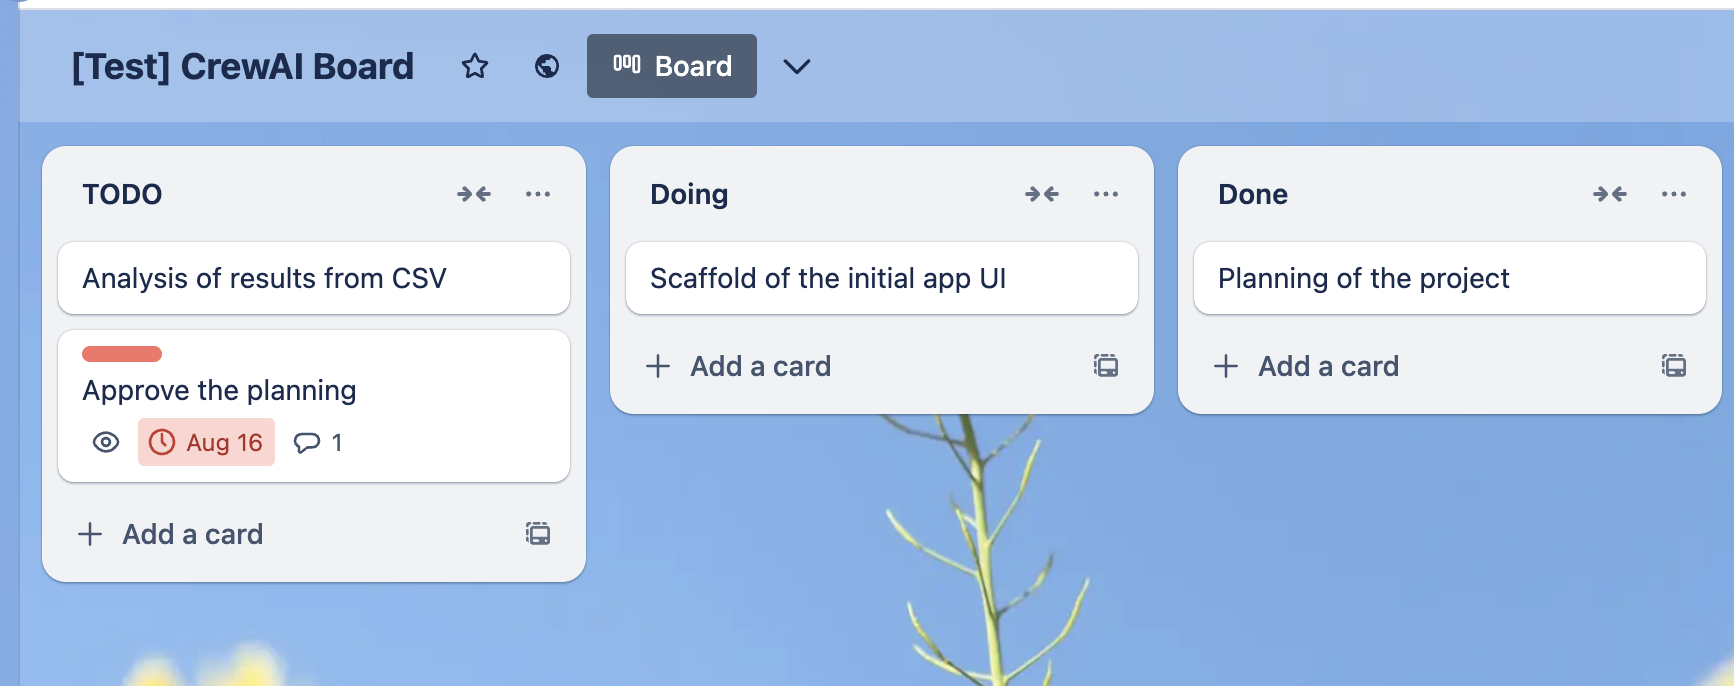

In [5]:
# Display the Trello screenshot
from IPython.display import Image, display

# Load and display the image
trello_image = Image(filename='trello.png')
display(trello_image)

## Create Crew, Agents and Tasks

In [6]:
# Creating Agents
data_collection_agent = Agent(
  config=agents_config['data_collection_agent'],
  tools=[BoardDataFetcherTool(), CardDataFetcherTool()]
)

analysis_agent = Agent(
  config=agents_config['analysis_agent']
)

# Creating Tasks
data_collection = Task(
  config=tasks_config['data_collection'],
  agent=data_collection_agent
)

data_analysis = Task(
  config=tasks_config['data_analysis'],
  agent=analysis_agent
)

report_generation = Task(
  config=tasks_config['report_generation'],
  agent=analysis_agent,
)

# Creating Crew
crew = Crew(
  agents=[
    data_collection_agent,
    analysis_agent
  ],
  tasks=[
    data_collection,
    data_analysis,
    report_generation
  ],
  verbose=True
)

## Kickoff Crew

In [7]:
# Kick off the crew and execute the process
result = crew.kickoff()

# Agent: Data Collection Specialist
## Task: Create an initial understanding of the project, its main features and the team working on it. Use the Trello Data Fetcher tool to gather data from the Trello board.



# Agent: Data Collection Specialist
## Thought: I need to gather all relevant data from the Trello board to create a comprehensive report on the project, its features, and the team involved.
## Using tool: Trello Board Data Fetcher
## Tool Input: 
"{}"
## Tool Output: 
[{'id': '66c3bfed69b473b8fe9d922e', 'name': 'Analysis of results from CSV', 'idList': '66c308f676b057fdfbd5fdb3', 'due': None, 'dateLastActivity': '2024-08-19T21:58:05.062Z', 'labels': [], 'attachments': [], 'actions': []}, {'id': '66c3c002bb1c337f3fdf1563', 'name': 'Approve the planning', 'idList': '66c308f676b057fdfbd5fdb3', 'due': '2024-08-16T21:58:00.000Z', 'dateLastActivity': '2024-08-19T21:58:57.697Z', 'labels': [{'id': '66c305ea10ea602ee6e03d47', 'idBoard': '66c305eacab50fcd7f19c0aa', 'idOrganization': '6



# Agent: Data Collection Specialist
## Final Answer: 
**Project Report**

**Project Title: [Test] CrewAI Board**

**1. Overview:**
This project focuses on creating a high-functioning app, with various stages of analysis, planning, and UI development.

**2. Main Features:**
- **Analysis of Results from CSV**  
  - Status: To Do  
  - URL: [Analysis of results from CSV](https://trello.com/c/GjHNaKq3/2-analysis-of-results-from-csv)  
  - Last Active: August 19, 2024  
  - Comments: None  

- **Approve the Planning**  
  - Status: To Do  
  - Due Date: August 16, 2024  
  - URL: [Approve the planning](https://trello.com/c/K3abXIMm/5-approve-the-planning)  
  - Last Active: August 19, 2024  
  - Comments: 1 (Joao Moura commented: "This was harder than expected, it's late")  
  - Label: Urgent (Red)

- **Scaffold of the Initial App UI**  
  - Status: To Do  
  - URL: [Scaffold of the initial app UI](https://trello.com/c/Qv9IHf78/3-scaffold-of-the-initial-app-ui)  
  - Last Active: August 1

## Usage Metrics and Costs

Let’s see how much it would cost each time if this crew runs at scale.

In [8]:
import pandas as pd

costs = 0.150 * (crew.usage_metrics.prompt_tokens + crew.usage_metrics.completion_tokens) / 1_000_000
print(f"Total costs: ${costs:.4f}")

# Convert UsageMetrics instance to a DataFrame
df_usage_metrics = pd.DataFrame([crew.usage_metrics.dict()])
df_usage_metrics

Total costs: $0.0033


,total_tokens,prompt_tokens,completion_tokens,successful_requests
0,21969,18130,3839,11


## Report

In [9]:
from IPython.display import Markdown

markdown  = result.raw
Markdown(markdown)

# Project Analysis Report for [Test] CrewAI Board

## Sprint Overview
This report outlines the current status of the [Test] CrewAI project, highlighting the key issues that have impacted the overall progress and identifying the necessary steps to facilitate momentum in upcoming sprints.

## Task Summary
- **Total Number of Tasks:** 10
- **Tasks in "To Do":** 10
- **Tasks in "In Progress":** 0
- **Tasks Completed:** 0

## Identified Issues and Blockers
1. **Lack of Progress on Key Features:**  
   All major tasks currently reside in the "To Do" status, indicating a complete standstill in development. This represents a critical bottleneck in our workflow, preventing the project from advancing.

2. **Urgent Task with Delayed Approvals:**  
   The task "Approve the Planning" is marked as urgent and has surpassed its due date (August 16, 2024). Joao Moura's feedback suggests challenges faced during this phase, indicating a need for reevaluation of our resources and processes to avoid similar delays.

3. **Stalled Communication:**  
   There is a significant lack of comments on tasks, suggesting that team members are not engaging actively. This absence of communication could lead to misunderstandings and further delays as the planning phase progresses.

## Progress and Delays
- **Current Progress:** The project is experiencing stagnation, with nothing moving to "In Progress" status.
- **Delays:** The overdue task "Approve the Planning" has created a significant bottleneck, preventing other dependent tasks from being addressed. These include:
  - "Scaffold of the Initial App UI"
  - "Planning of the Project"
  - "Analysis of Results from CSV"

All tasks remain unaddressed due to the standstill on planning approvals, indicating a domino effect that could derail project timelines.

## Team Performance Overview
- Overall team engagement appears low due to unclear communication channels and absence of discussions around tasks. The limited interaction among team members could lead to further delays and reduced productivity moving forward.

## Action Items and Recommendations
1. **Schedule a Focused Meeting:**  
   Organize a meeting to clearly address the planning issues, allowing Joao to share specific challenges. This could help surface unaddressed blockers and re-align the team on project goals.

2. **Assign Clear Deadlines and Responsibilities:**  
   Establish specific deadlines for each task along with designated team members responsible for them. This will instill accountability and ensure timely progress.

3. **Encourage Ongoing Dialogue:**  
   Foster a culture of open communication on the Trello board to promote collaboration and keep the team engaged and updated on activities.

4. **Re-evaluate Resources:**  
   Investigate the potential need for additional resources or personnel to assist in overcoming the specific challenges presented in the planning phase, ensuring future tasks can progress without delay.

By addressing these critical issues, engaging the team effectively, and implementing the recommended action items, we can mitigate further delays and create a more streamlined project trajectory moving forward.